In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import akross_common_functions as AK

# Import saline snow permittivity model
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.inputs import altimeter_list
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10

pd.set_option('mode.chained_assignment',None)

This notebook contains the following 2 sections

1. Plot volume fraction (density) of all intruments at AK1 
2. SMRT simulation of micro-CT, snowpit and smp


import all files

In [4]:
#Get FYI 
#get smp profile for CB at different resolution
with open('smrt_in-out/smp_profile_CB_5cm', 'rb') as pickle_file:
    smp_5cm = pickle.load(pickle_file)

with open('smrt_in-out/smp_profile_CB_1cm', 'rb') as pickle_file:
    smp_1cm = pickle.load(pickle_file)

list_smp_AK1_5cm = [profile for name, profile in smp_5cm['AK1'].items()]
list_smp_AK1_1cm = [profile for name, profile in smp_1cm['AK1'].items()]

In [5]:
#get pit
with open('smrt_in-out/snowpitCB2022_SMRT_input.txt', 'rb') as pickle_file:
    pit = pickle.load(pickle_file)
    
pit_AK1 = pit['AK1']
pit_AK2 = pit['AK2']
pit_AK3 = pit['AK3']
pit_AK4 = pit['AK4']

In [8]:
#need CT data from zenodo DOI: ....

#get CT data
microCT_file = "../Dataset_AKROSS/micro_CT/AK1_unc.csv"
micro_AK1 = pd.read_csv(microCT_file)
microCT_file = "../Dataset_AKROSS/micro_CT/AK2_unc.csv"
micro_AK2 = pd.read_csv(microCT_file)
microCT_file = "../Dataset_AKROSS/micro_CT/AK3_unc.csv"
micro_AK3 = pd.read_csv(microCT_file)
microCT_file = "../Dataset_AKROSS/micro_CT/AK4_unc.csv"
micro_AK4 = pd.read_csv(microCT_file)

### 1. Plot volume fraction (density) of all intruments at AK1 

(smp 1cm, smp 5 cm, CT and tradionnal pit)

In [9]:
#get info for first smp that correspond to the closest to the pit
#smp S40M1503 - 06 are close to pit but smaller thickness
#smp #S40M1514 has a similar thickness
smp_5cm['AK1']['S40M1503.pnt']

,distance,density,ssa,temperature,salinity,thick
40,25.625,377.527495,27.454675,251.150000,0.58,0.05
80,75.625,349.189230,26.023193,251.261111,0.70,0.05
120,125.625,359.177992,25.473620,251.816667,3.84,0.05


In [10]:
smp1 = smp_5cm['AK1']['S40M1505.pnt']
smp2 = smp_1cm['AK1']['S40M1505.pnt']

In [22]:
print(f'mean for pit {np.mean(pit_AK1.density/917)}, mean for ct {np.mean(micro_AK1.volume_fraction[::-1])}')
print(f'std for pit {np.std(pit_AK1.density/917)}, std for ct {np.std(micro_AK1.volume_fraction[::-1])}')

mean for pit 0.4016721192293711, mean for ct 0.3775241048411651
std for pit 0.032206552429424475, std for ct 0.06442992342876695


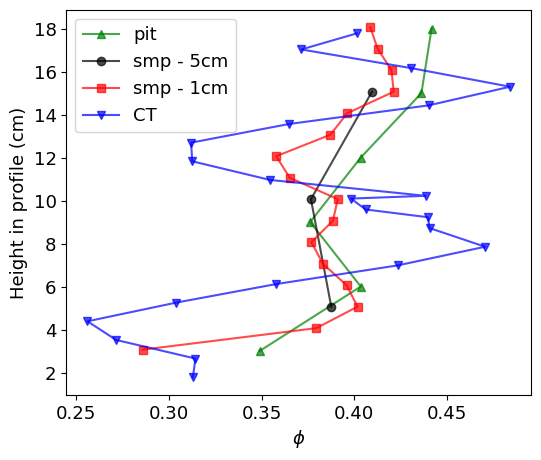

In [20]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize = (6,5))
plt.plot(pit_AK1.density/917, pit_AK1.htop*100 - 1, 'g^-', label = 'pit', alpha = 0.7)
plt.plot(smp1.density/917, smp1.distance[::-1]/10 + 2.5, 'ko-', label = 'smp - 5cm', alpha = 0.7)
plt.plot(smp2.density/917, smp2.distance[::-1]/10 + 2.5, 'rs-', label = 'smp - 1cm', alpha = 0.7)
plt.plot(micro_AK1.volume_fraction[::-1], micro_AK1.height_in_profile[::-1] /10, 'bv-', label = 'CT', alpha = 0.7)
plt.xlabel('$\phi$')
plt.ylabel('Height in profile (cm)')
plt.legend()
#plt.savefig('C:/Users/melochej/OneDrive - EC-EC/Documents/post-doc/AKROSS/article/fig_output/volume_Fraction.png', dpi=300, format='png', bbox_inches='tight')

### 2. SMRT simulation of micro-CT, snowpit and smp

In [12]:
#set mean roughness value for snow and ice from AKROSS campaign
# value of ice rms from global_norm_factor
mean_ice_rms_fyi = 0.002
mean_ice_rms_myi = 0.003
# value measured
mean_ice_lc = 0.15
mean_snow_rms = 0.004
mean_snow_lc = 0.12

#norm factor
normf = 1.4e-9

altimodel = make_model("iba", "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8))
cryosat = altimeter_list.cryosat2_sin()

In [13]:
list_smp_AK1_5cm = [profile for name, profile in smp_5cm['AK1'].items()]
list_smp_AK1_1cm = [profile for name, profile in smp_1cm['AK1'].items()]

AK1_5cm_sp = AK.build_snowpack_pickle(list_smp_AK1_5cm)
AK1_1cm_sp = AK.build_snowpack_pickle(list_smp_AK1_1cm)
#Create snowpack for SMP measurements
  
AK.change_roughness(AK1_5cm_sp, mean_ice_rms_fyi, mean_ice_lc, mean_snow_rms, mean_snow_lc)    
AK.change_roughness(AK1_1cm_sp, mean_ice_rms_fyi, mean_ice_lc, mean_snow_rms, mean_snow_lc)   

In [14]:
def build_snowpack_CT(micro_csv, pit_info, ssa_debye = False):
    """
    Build SMRT snowpack for CT, different than for SMP in akros_common_functions
    """

    #thickness micro CT in mm
    thick_micro = (micro_csv.height_in_profile.values[5] - micro_csv.height_in_profile.values[4])
    #thick array in meters
    thick_array = np.ones(len(micro_csv.height_in_profile.values)) * thick_micro /1000
    
    #get l_exp from mean of all three direction,convert to meter
    #fit from autocorrelation
    l_c_exp = np.mean([micro_csv['EXP_xi_r_x_size/6'], micro_csv['EXP_xi_r_y_size/6'], micro_csv['EXP_xi_r_z_size/6']], axis =0)/1000
    
    #get l_c from slope of ACF
    if ssa_debye == True:
        debye_factor = 0.75
        l_c_exp = debye_factor *np.mean([micro_csv['lc_x'], micro_csv['lc_y'], micro_csv['lc_z']], axis =0)/1000
    
    temperature_micro = np.interp(micro_csv.height_in_profile[::-1]/10, pit_info.htop*100, pit_info.temperature[::-1])
    salinity_micro = np.interp(micro_csv.height_in_profile[::-1]/10, pit_info.htop*100, pit_info.salinity[::-1])

    df_micro = pd.DataFrame({' htop' : micro_csv.height_in_profile[::-1]/10, 'thick' : thick_array, 'density' : micro_csv.volume_fraction[::-1] *917,
                             'temperature' : temperature_micro, 'salinity' : salinity_micro, 'l_exp' : l_c_exp[::-1]})
    
    #Create snowpack for microCT
    sea_ice_density = 910
    ice = make_ice_column(ice_type='firstyear',
            thickness=[2], temperature=260, 
            microstructure_model='independent_sphere',
            radius=1e-3,
            brine_inclusion_shape='spheres',
            density=sea_ice_density,
            salinity= 5*PSU,
            add_water_substrate=True)

    snowpack_micro = make_snowpack(df_micro.thick, microstructure_model='exponential',
                    ice_permittivity_model=ssp, density=df_micro.density , 
                    corr_length=df_micro.l_exp, temperature = df_micro.temperature,
                    salinity=df_micro.salinity *PSU) + ice
    #ice
    snowpack_micro.interfaces[-1] = make_interface(IEM_Fung92_Briogoni10, roughness_rms = mean_ice_rms_fyi, corr_length = mean_ice_lc)
    #surface
    snowpack_micro.interfaces[0] = make_interface(IEM_Fung92_Briogoni10, roughness_rms = mean_snow_rms, corr_length = mean_snow_lc)
    
    return snowpack_micro

#Create snowpack for snowpit
def build_snowpack_pit(pit_site):
    """
    Build SMRT snowpack for pit, different than for SMP in akros_common_functions
    """
    # Convert to exp. corr length
    debye = 0.75
    lex_array = debye * 4 * (1 - pit_site.density / 917) / (pit_site.ssa * 917)

    #Create snowpack for microCT
    sea_ice_density = 910
    ice = make_ice_column(ice_type='firstyear',
            thickness=[2], temperature=260, 
            microstructure_model='independent_sphere',
            radius=1e-3,
            brine_inclusion_shape='spheres',
            density=sea_ice_density,
            salinity=5*PSU,
            add_water_substrate=True)

    snowpack_pit = make_snowpack(pit_site.thick, microstructure_model='exponential',
                    ice_permittivity_model=ssp, density=pit_site.density , 
                    corr_length=lex_array, temperature = 260,
                    salinity=pit_site.salinity *PSU) + ice
    #ice
    snowpack_pit.interfaces[-1] = make_interface(IEM_Fung92_Briogoni10, roughness_rms = mean_ice_rms_fyi, corr_length = mean_ice_lc)
    #surface
    snowpack_pit.interfaces[0] = make_interface(IEM_Fung92_Briogoni10, roughness_rms = mean_snow_rms, corr_length = mean_snow_lc)
    
    return snowpack_pit

In [15]:
#build snowpack for CT
snowpack_CT_AK1 = build_snowpack_CT(micro_AK1, pit_AK1)
snowpack_CT_AK2 = build_snowpack_CT(micro_AK2, pit_AK2)
snowpack_CT_AK3 = build_snowpack_CT(micro_AK3, pit_AK3)
snowpack_CT_AK4 = build_snowpack_CT(micro_AK4, pit_AK4)

#build snowpack from pit
snowpack_pit_AK1 = build_snowpack_pit(pit_AK1)
snowpack_pit_AK2 = build_snowpack_pit(pit_AK2)
snowpack_pit_AK3 = build_snowpack_pit(pit_AK3)
snowpack_pit_AK4 = build_snowpack_pit(pit_AK4)


In [16]:
#run simulation

#smp
res_smp_5cm = np.mean(altimodel.run(cryosat, AK1_5cm_sp).sigma(), axis = 0)
res_smp_1cm = np.mean(altimodel.run(cryosat, AK1_1cm_sp).sigma(), axis = 0)

#CT
res_CT_AK1 = altimodel.run(cryosat, snowpack_CT_AK1).sigma()
res_CT_AK2 = altimodel.run(cryosat, snowpack_CT_AK2).sigma()
res_CT_AK3 = altimodel.run(cryosat, snowpack_CT_AK3).sigma()
res_CT_AK4 = altimodel.run(cryosat, snowpack_CT_AK4).sigma()

#pit
res_pit_AK1 = altimodel.run(cryosat, snowpack_pit_AK1).sigma()
res_pit_AK2 = altimodel.run(cryosat, snowpack_pit_AK2).sigma()
res_pit_AK3 = altimodel.run(cryosat, snowpack_pit_AK3).sigma()
res_pit_AK4 = altimodel.run(cryosat, snowpack_pit_AK4).sigma()

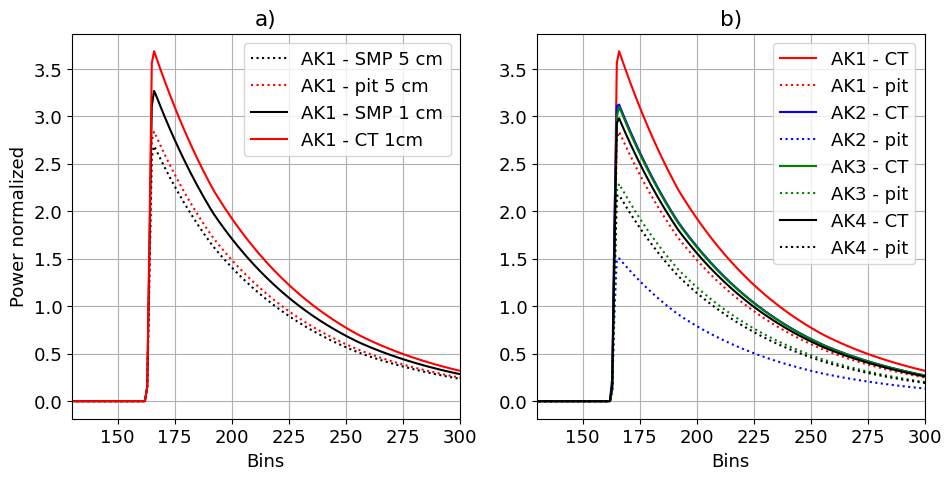

In [17]:
plt.rcParams.update({'font.size': 13})
fig, (ax1, ax2) =plt.subplots(nrows=1, ncols=2, figsize = (11,5), sharex = True)

ax1.plot(res_smp_5cm/normf/1e-14, 'k:', label = 'AK1 - SMP 5 cm')
ax1.plot(res_pit_AK1/normf/1e-14, 'r:', label = 'AK1 - pit 5 cm')
ax1.plot(res_smp_1cm/normf/1e-14, 'k-', label = 'AK1 - SMP 1 cm')
ax1.plot(res_CT_AK1/normf/1e-14, 'r-', label = 'AK1 - CT 1cm')
ax1.legend()
ax1.grid()


ax2.plot(res_CT_AK1/normf/1e-14, 'r-', label = 'AK1 - CT')
ax2.plot(res_pit_AK1/normf/1e-14,'r:', label = 'AK1 - pit')
ax2.plot(res_CT_AK2/normf/1e-14, 'b-', label = 'AK2 - CT')
ax2.plot(res_pit_AK2/normf/1e-14,'b:', label = 'AK2 - pit')
ax2.plot(res_CT_AK3/normf/1e-14, 'g-', label = 'AK3 - CT')
ax2.plot(res_pit_AK3/normf/1e-14,'g:', label = 'AK3 - pit')
ax2.plot(res_CT_AK4/normf/1e-14, 'k-', label = 'AK4 - CT')
ax2.plot(res_pit_AK4/normf/1e-14,'k:', label = 'AK4 - pit')

ax2.legend()
plt.xlim(130,300)
ax1.set_title('a)')
ax2.set_title('b)')
ax1.set_xlabel('Bins')
ax2.set_xlabel('Bins')
ax1.set_ylabel('Power normalized')
ax2.grid()

#plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/simu_CT_subfig.png', dpi=300, format='png', bbox_inches='tight')